## COMP5328 - Advanced Machine Learning
## Assignment 1: Non-negative Matrix Factorization
----------------------------------------------------------------------------------------

**(Semester 2, 2025)**

In this ipython notebook, we provide some example code for assignment1.
+ Load Data.
    - ORL dataset. 
    - Extended YaleB dataset. 
    - AR dataset (**optional**).
+ Perform Evaluation. 
   - Relative Reconstruction Errors.
   - Accuracy, NMI (**optional**).

Lecturer: Tongliang Liu.

**Note: All datasets can be used only for this assignment and you are not allowed to distribute these datasets. If you want to use AR dataset, you need to apply it by yourself (we do not provide AR dataset due to the problem of license, please find more details in http://www2.ece.ohio-state.edu/~aleix/ARdatabase.html).**

## 1. Load Dataset

### 1.0 Data Folder

In [1]:
import os, warnings
os.environ["OMP_NUM_THREADS"] = "2"   # 避免 MKL+Windows 这个 known issue 的内存警告
warnings.filterwarnings(
    "ignore",
    message="KMeans is known to have a memory leak on Windows with MKL",
    category=UserWarning
)

In [2]:
# The structure of data folder.
!ls -l data

'ls' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


### 1.1 Load ORL Dataset and Extended YaleB Dataset.
+ ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

+ Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [3]:
import os
import numpy as np
from PIL import Image

#record the path to reload the origin data

def load_data(root='data/CroppedYaleB'):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels,paths = [], [],[]

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            #new -record the path
            img_path = os.path.join(root, person, fname)
            img = img.convert('L') # grey image.

            # TODO: preprocessing.
            # --- c fixed size (keeps PIL (W,H) order) ---
            root_name = os.path.basename(os.path.normpath(root)).lower()

            # --- normalize to [0,1] (nonnegative, NMF-safe) ---
            arr = np.asarray(img, dtype=np.float64) / 255.0
            # convert image to numpy column vector (after preprocessing).
            img = arr.reshape((-1, 1))

            #no-normalize
            img = np.asarray(img).reshape((-1,1))




            # collect data and label.
            images.append(img)
            labels.append(i)
            #collect the path
            paths.append(img_path)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels,paths

In [4]:
# Load ORL dataset.
X_orl, Y_orl,P_orl = load_data(root='data/ORL')
print('ORL dataset: X_orl.shape = {}, Y_orl.shape = {}'.format(X_orl.shape, Y_orl.shape))

# Load Extended YaleB dataset.
X_yale, Y_yale,P_yale = load_data(root='data/CroppedYaleB')
print('Extended YalB dataset: X_yale.shape = {}, Y_yale.shape = {}'.format(X_yale.shape, Y_yale.shape))

ORL dataset: X_orl.shape = (10304, 400), Y_orl.shape = (400,)
Extended YalB dataset: X_yale.shape = (32256, 2414), Y_yale.shape = (2414,)


In [5]:
# save the processed dataset
np.savez("ORL_preprocessed_p_1.npz",X=X_orl,Y=Y_orl,paths = np.array(P_orl, dtype=object))
np.savez("CroppedYaleB_preprocessed_p_1.npz",X=X_yale,Y=Y_yale,paths = np.array(P_yale, dtype=object))

## 2. 胡椒函数 +对应的噪音图展示 + L2-NMF代码实现 + NMF之后的可视化展示

### 2.1 胡椒函数+对应的噪音图展示


(10304, 400)


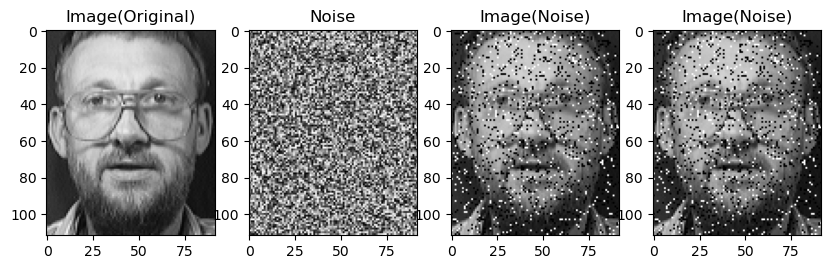

CPU times: total: 1.92 s
Wall time: 2.78 s


In [6]:
%%time
#调整参数 胡椒的参数，变小了。调整一下迭代的公式-和老师一模一样；我再调整一下把，把那个数字也一样。用归一化。然后迭代60次
import numpy as np
def salt_pepper_noise(img,p=0,r=0 ):
    #p adjust the pixel values; r adjust salt value
    img_shape = img.shape
    print(img_shape)
    img_after = img.copy()
    V_noise = np.random.rand(*img_shape)
    img_after[V_noise<p] = 0
    img_after[V_noise>1-r] = 1
    
    
    return V_noise,img,img_after
        
    
# 加载处理后的数据.那就是像素大纯粹是因为我压缩了图片
# data = np.load("ORL_preprocessed.npz")   # 或 "yaleb_dataset.npz"
data = np.load("ORL_preprocessed_p_1.npz",allow_pickle=True)   # 或 "yaleb_dataset.npz"
V_hat, Y_hat= data["X"], data["Y"]

##上面是加载数据的

V_noise, V_hat ,V  = salt_pepper_noise(img=V_hat,p=0.1,r=0.05 )

# Plot result. 
import matplotlib.pyplot as plt

H_img, W_img = 112, 92 

ind = 50 # index of demo image.
plt.figure(figsize=(10,4))
plt.subplot(141)
plt.imshow(V_hat[:,ind].reshape(H_img, W_img), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(142)
plt.imshow(V_noise[:,ind].reshape(H_img, W_img), cmap=plt.cm.gray)
plt.title('Noise')
plt.subplot(143)
plt.imshow(V[:,ind].reshape(H_img, W_img), cmap=plt.cm.gray,vmin= 0,vmax=1)
plt.title('Image(Noise)')
plt.subplot(144)
plt.imshow(V[:,ind].reshape(H_img, W_img), cmap=plt.cm.gray)
plt.title('Image(Noise)')
plt.show()








In [7]:
"""计算两个目标值之间的相对改进量"""
def relative_improvement(prev_obj, curr_obj, eps=1e-12):
    return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)

#定义统一的可视化函数
def visualize_reconstruction(V_hat, V_noisy, V_recon, ind=50, img_size=(92,112), title="NMF Reconstruction"):
    plt.suptitle(title, size=16)

    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(V_hat[:, ind].reshape(img_size), cmap=plt.cm.gray)
    plt.title("Image (Original)")

    plt.subplot(132)
    plt.imshow(V_noisy[:, ind].reshape(img_size), cmap=plt.cm.gray)
    plt.title("Image (Noisy)")

    plt.subplot(133)
    plt.imshow(V_recon[:, ind].reshape(img_size), cmap=plt.cm.gray)
    plt.title("Image (Reconstructed)")

    plt.show()
    
eps = 1e-12

### 2.2 L1-NMF代码实现+实现后的效果可视化

final run step: 60


<Figure size 640x480 with 0 Axes>

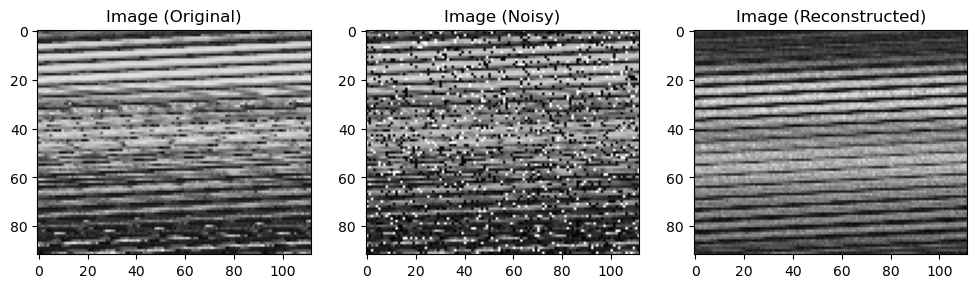

In [8]:
def L1_nmf(V, H, W, steps=3000, tol=1e-5, verbose=False):

    obj_prev = np.sum(np.abs(V - W @ H))
    for step in range(1, steps + 1):
        # 残差与权重（IRLS）：Q_ij = 1/(|E_ij| + eps)
        E  = V - (W @ H)
        Q  = 1.0 / (np.abs(E) + eps)

        # 乘法更新（带逐元素权重的加权-L2 形式）
        # H <- H .* (W^T (Q ⊙ V)) / (W^T (Q ⊙ (W H)))
        H *= (W.T @ (Q * V)) / (W.T @ (Q * (W @ H)) + eps)

        # W <- W .* ((Q ⊙ V) H^T) / ((Q ⊙ (W H)) H^T)
        WH = W @ H
        W *= ((Q * V) @ H.T) / (((Q * WH) @ H.T) + eps)

        # 目标与收敛
        obj = np.sum(np.abs(V - W @ H))
        rel = relative_improvement(obj_prev, obj, eps=eps)
        if verbose and (step % 100 == 0):
            print(f"[L1-NMF] step={step}, obj={obj:.6e}, rel={rel:.3e}")
        if rel < tol:
            if verbose:
                print(f"[L1-NMF] Converged at step={step}, obj={obj:.6e}, rel={rel:.3e}")
            break
        obj_prev = obj

    return H, W, step

# init
# set seed 
N  = V.shape[1] #samples
M = V.shape[0] #dimension

rng = np.random.RandomState(2025)

K=40
W = rng.rand(M,K)
H = rng.rand(K,N)

# NMF
H_star,W_star,step =  L1_nmf(V,H,W,steps=60,tol = 1e-5)
print("final run step:",step)

#watch the best new face
V_star = W_star.dot(H_star)

#visualization
visualize_reconstruction(V_hat, V, V_star, ind=50, img_size=(92,112), title="L1 NMF Reconstruction")

### 2.3 L2-NMF代码实现+实现后的效果可视化


For any data matrix $X$, L2-NMF finds non-negative factors $D \in \mathbb{R}^{w \times k}_{+}$ and $R \in \mathbb{R}^{k \times n}_{+}$ such that
$$
X \approx DR,
$$
by minimizing the Frobenius reconstruction error
$$
\min_{D,R \ge 0}\ \lVert X - DR \rVert_F^2 .
$$

Using multiplicative update rules (MUR), the iteration can be written as
$$
R \leftarrow R \odot \frac{D^\top X}{D^\top D R}, \qquad
D \leftarrow D \odot \frac{X R^\top}{D R R^\top},
$$
where $\odot$ denotes element-wise multiplication.



---------------------------


final run step: 60


<Figure size 640x480 with 0 Axes>

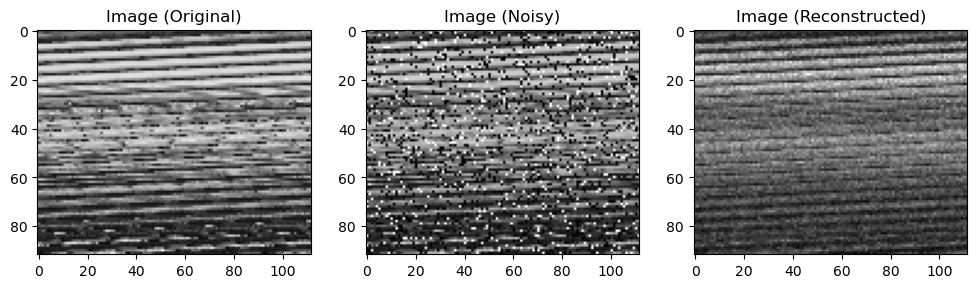

In [9]:
def L2_NMF(V,H,W,steps,tol=1e-5,verbose=False):
    # H is coeffient matrix
    # W is dictionary matrix
    # V is the matrix with noise
    #V hat  is the original matrix
    # print("basic_NMF")
    obj_prev = np.linalg.norm(V - W @ H, 'fro')**2
    
    for step in range(1, steps+1):    

        H_star = H * (W.T.dot(V)) / (W.T.dot(W).dot(H) + eps)
        W_star = W * (V.dot(H_star.T)) / (W.dot(H_star.dot(H_star.T)) + eps)

        H, W = H_star, W_star

        obj = np.linalg.norm(V - W @ H, 'fro')**2

        rel_impr = relative_improvement(obj_prev, obj, eps=eps)

        if rel_impr < tol:
            if verbose:
                print(f"Converged at step={step}, obj={obj:.6e}, rel_impr={rel_impr:.3e}")
            break

        obj_prev = obj

        if verbose and step in (1000, 5000, 10000, 15000, 20000):
            print(f"step={step}, obj={obj:.6e}, rel_impr={rel_impr:.3e}")

    return H, W, step

# init
# set seed 
N  = V.shape[1] #samples
M = V.shape[0] #dimension

rng = np.random.RandomState(2025)

K=40
W = rng.rand(M,K)
H = rng.rand(K,N)

# NMF
H_star,W_star,step =  L2_NMF(V,H,W,steps=60,tol = 1e-5)
print("final run step:",step)

#watch the best new face
V_star = W_star.dot(H_star)

#visualization
visualize_reconstruction(V_hat, V, V_star, ind=50, img_size=(92,112), title="L2 NMF Reconstruction")

In [10]:
#save file
np.savez("ORL_preprocessed_p_1.npz",X=V_star)

### 2.4 L2,1-NMF代码实现+实现后的效果可视化

[L2,1-NMF] step=100, obj=4.276695e+04, rel=4.280e-04
[L2,1-NMF] step=200, obj=4.191501e+04, rel=9.528e-05
[L2,1-NMF] step=300, obj=4.165220e+04, rel=4.194e-05
L2,1-NMF final run step: 300


<Figure size 640x480 with 0 Axes>

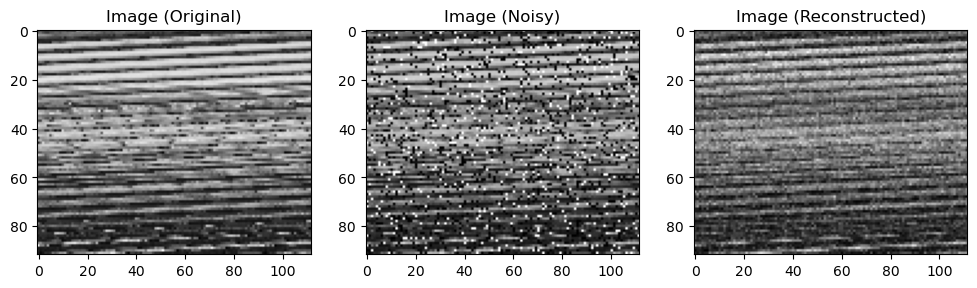

In [11]:
def L21_nmf(V, H, W, steps=3000, tol=1e-5, verbose=False):

    def L21_obj(E):
        return np.sum(np.sqrt(np.sum(E * E, axis=1) + eps))

    obj_prev = L21_obj(V - W @ H)

    for step in range(1, steps + 1):
        # 残差 & 行权重
        E = V - (W @ H)                               # (d, n)
        row_norm = np.sqrt(np.sum(E * E, axis=1) + eps)  # (d,)
        s = 1.0 / (row_norm + eps)                    # (d,)

        # 广播实现 S = diag(s)
        SV  = s[:, None] * V
        SWH = s[:, None] * (W @ H)

        # H <- H .* (W^T (S V)) / (W^T (S W H))
        H *= (W.T @ SV) / (W.T @ SWH + eps)

        # W <- W .* ((S V) H^T) / ((S W H) H^T)
        SWH = s[:, None] * (W @ H)                    # 用更新后的 H 重新计算
        W  *= (SV @ H.T) / (SWH @ H.T + eps)

        # 收敛判定（相对改进）
        obj = L21_obj(V - W @ H)
        rel = relative_improvement(obj_prev, obj, eps=eps)
        if verbose and (step % 100 == 0):
            print(f"[L2,1-NMF] step={step}, obj={obj:.6e}, rel={rel:.3e}")
        if rel < tol:
            if verbose:
                print(f"[L2,1-NMF] Converged at step={step}, obj={obj:.6e}, rel={rel:.3e}")
            break
        obj_prev = obj

    return W, H, step

# ============ init ============
N  = V.shape[1]
M  = V.shape[0]
K  = 40

rng = np.random.RandomState(2025)
W0 = rng.rand(M, K)
H0 = rng.rand(K, N)

# ============ L2,1-NMF run ============
W_l21, H_l21, step = L21_nmf(V, H0, W0, steps=300, tol=1e-5, verbose=True)
print("L2,1-NMF final run step:", step)

V_l21 = W_l21 @ H_l21

# ============ visualization ============
visualize_reconstruction(V_hat, V, V_l21, ind=50, img_size=(92,112), title="L2,1-NMF Reconstruction")

### 2.5 CIM-NMF代码实现+实现后的效果可视化

For any data matrix $X$, CIM-NMF finds non-negative factors 
$D \in \mathbb{R}_+^{d \times k}$ and 
$R \in \mathbb{R}_+^{k \times n}$ such that

$$
X \approx DR,
$$

by minimizing the Correntropy-Induced Metric (CIM) reconstruction error:

$$
\min_{D,R \ge 0} \sum_{i=1}^d \sum_{j=1}^n 
\left( 1 - \frac{1}{\sqrt{2\pi}\delta} 
\exp\!\left(-\frac{(X_{ij} - (DR)_{ij})^2}{2\delta^2}\right) \right).
$$

---

### Multiplicative Update Rules (MUR)

Using the weight matrix

$$
W_{ij} = \frac{1}{\sqrt{2\pi}\delta} 
\exp\!\left(-\frac{(X_{ij} - (DR)_{ij})^2}{2\delta^2}\right),
$$

the iteration can be written as

$$
R \leftarrow R \odot \frac{D^\top (W \odot X)}{D^\top (W \odot (DR))}, 
\qquad
D \leftarrow D \odot \frac{(W \odot X) R^\top}{(W \odot (DR)) R^\top},
$$

where $\odot$ denotes element-wise multiplication.

C:\Users\hdq\AppData\Local\Temp\ipykernel_4368\3679991400.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return abs(prev_obj - curr_obj) / (abs(prev_obj) + eps)


[CIM-NMF] iter=50, obj=2.513638e+06, rel_impr=4.751e-05
[CIM-NMF] iter=100, obj=2.510756e+06, rel_impr=1.142e-05
[CIM-NMF] Converged at iter=107, obj=2.510571e+06, rel_impr=9.884e-06
CIM-NMF final run step: 107


<Figure size 640x480 with 0 Axes>

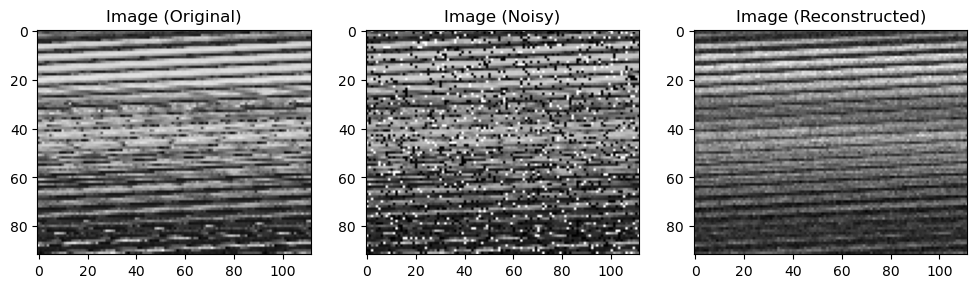

In [12]:
def cim_nmf(V, k, delta=1.0, max_iter=300, tol=1e-5, rng=None, verbose=False):
    """
    CIM-NMF (Correntropy-Induced Metric NMF)
    min_{W,H >=0} sum_{ij} r((V-WH)_{ij}, delta)

    更新规则基于权重加权的 NMF:
      H <- H * (W^T (R ⊙ V)) / (W^T (R ⊙ WH))
      W <- W * ((R ⊙ V) H^T) / ((R ⊙ WH) H^T)
    其中 R = exp(-(E^2)/(2 delta^2)) / (sqrt(2π) delta)
    """

    m, n = V.shape
    rng = np.random.default_rng(rng)
    W = np.maximum(rng.random((m, k)), 1e-8)
    H = np.maximum(rng.random((k, n)), 1e-8)

    obj_prev = np.inf
    eps = 1e-12

    for it in range(1, max_iter + 1):
        # restucture
        V_hat = W @ H
        E = V - V_hat

        R = np.exp(-(E**2) / (2 * delta**2)) / (np.sqrt(2*np.pi) * delta)

        obj = np.sum(1 - R)

        # update H
        H *= (W.T @ (R * V)) / (W.T @ (R * V_hat) + eps)
        # update W
        V_hat = W @ H
        W *= ((R * V) @ H.T) / ((R * V_hat) @ H.T + eps)

        rel_impr = relative_improvement(obj_prev, obj, eps)
        if rel_impr < tol:
            if verbose:
                print(f"[CIM-NMF] Converged at iter={it}, obj={obj:.6e}, rel_impr={rel_impr:.3e}")
            break
        obj_prev = obj

        if verbose and it % 50 == 0:
            print(f"[CIM-NMF] iter={it}, obj={obj:.6e}, rel_impr={rel_impr:.3e}")

    return W, H, it

# ============ init ============
N  = V.shape[1]   
M  = V.shape[0]   

rng = np.random.RandomState(2025)
K = 40            # rank (number of classes)

# init W, H
W0 = rng.rand(M, K)
H0 = rng.rand(K, N)

# ============ CIM-NMF run ============
W_cim, H_cim, step = cim_nmf(V, k=K, delta=1.0, max_iter=300, tol=1e-5, rng=2025, verbose=True)
print("CIM-NMF final run step:", step)

V_cim = W_cim.dot(H_cim)

# ============ visualization ============
visualize_reconstruction(V_hat, V, V_cim, ind=50, img_size=(92,112), title="CIM-NMF Reconstruction")

## 3. Evaluation Metrics


### 3.1 Relative Reconstruction Errors (RRE)

To compare the robustness of different NMF algorithms, you can use the ```relative reconstruction errors```. Let $V$ denote the contaminated dataset (by adding noise), and $\hat{V}$
 denote the clean dataset. Let $W$ and $H$ denote the factorization results on $V$, the ``relative reconstruction errors`` then can be defined as follows:
 \begin{equation}
    RRE = \frac{ \| \hat{V} - WH \|_F }{ \| \hat{V} \|_F}.
\end{equation}


In [13]:
# # Evaluate relative reconstruction errors.
# print('==> Evaluate RRE ...')
# RRE = np.linalg.norm(V_hat - V_star) / np.linalg.norm(V_hat)
# print('RRE = {}'.format(RRE))

### 3.2 Evaluate Clustering Performance

1. Accuracy.
    
    $$ Acc(Y, Y_{pred}) = \frac{1}{n}\sum\limits_{i=1}^n 1\{Y_{pred}(i) == Y(i)\}$$
        
2. Normalized Mutual Information (NMI).

    $$ NMI(Y, Y_{pred}) = \frac{2 * I(Y, Y_{pred})}{H(Y) + H(Y_{pred})} $$
    
   where $ I(\cdot,\cdot) $ is mutual information and $ H(\cdot) $ is entropy.

In [14]:
#other evaluate -检测指标
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

# print('==> Evaluate Acc and NMI ...')

# # Assign cluster labels.
# Y_pred = assign_cluster_label(H.T, Y_hat)

# acc = accuracy_score(Y_hat, Y_pred)
# nmi = normalized_mutual_info_score(Y_hat, Y_pred)
# print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))

In [15]:
def load_orl():
    X_orl, Y_orl, P_orl = load_data(root='data/ORL')
    return X_orl, Y_orl 

def load_yaleb():
    X_yale, Y_yale, P_yale = load_data(root='data/CroppedYaleB')
    return X_yale, Y_yale


In [16]:
def add_salt_pepper_noise(V, p=0.1, r=0.05, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    V_noisy = V.copy()
    d, n = V.shape
    total_pixels = d * n
    num_corrupt = int(total_pixels * p)


    idx = rng.choice(total_pixels, size=num_corrupt, replace=False)
    num_white = int(num_corrupt * r)
    white_idx = idx[:num_white]
    black_idx = idx[num_white:]


    V_noisy.flat[white_idx] = 1.0
    V_noisy.flat[black_idx] = 0.0
    return V_noisy


In [17]:
# ===== L1 =====
def nmf_L1(V, rank, random_state=0, steps=3000, tol=1e-5, verbose=False):
    rng = np.random.default_rng(random_state)
    m, n = V.shape
    W = np.maximum(rng.random((m, rank)), 1e-8)
    H = np.maximum(rng.random((rank, n)), 1e-8)
    H, W, _ = L1_nmf(V, H, W, steps=steps, tol=tol, verbose=verbose)
    return W, H

# ===== L2=====
def nmf_L2(V, rank, random_state=0, steps=3000, tol=1e-5, verbose=False):
    rng = np.random.default_rng(random_state)
    m, n = V.shape
    W = np.maximum(rng.random((m, rank)), 1e-8)
    H = np.maximum(rng.random((rank, n)), 1e-8)
    H, W, _ = L2_NMF(V, H, W, steps=steps, tol=tol, verbose=verbose)
    return W, H

# ===== L2,1 =====
def nmf_L21(V, rank, random_state=0, steps=3000, tol=1e-5, verbose=False):
    rng = np.random.default_rng(random_state)
    m, n = V.shape
    W = np.maximum(rng.random((m, rank)), 1e-8)
    H = np.maximum(rng.random((rank, n)), 1e-8)
    H, W, _ = L21_nmf(V, H, W, steps=steps, tol=tol, verbose=verbose)
    return W, H

# ===== CIM =====
def nmf_CIM(V, rank, random_state=0, max_iter=300, tol=1e-5, verbose=False, **kwargs):
    rng = np.random.default_rng(random_state)
    W, H = cim_nmf(V, k=rank, max_iter=max_iter, tol=tol, rng=rng, verbose=verbose, **kwargs)
    return W, H


In [18]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, accuracy_score


def compute_RRE(V_clean, W, H):
    # RRE = ||V̂ - WH||_F / ||V̂||_F
    num = np.linalg.norm(V_clean - W @ H, ord='fro')
    den = np.linalg.norm(V_clean, ord='fro') + 1e-12
    return num / den

def cluster_and_metrics(H, y_true, n_classes=None, with_acc=True, with_nmi=True, random_state=0):
    if n_classes is None:
        n_classes = len(set(y_true))

    km = KMeans(n_clusters=n_classes, n_init=10, random_state=random_state)
    y_pred = km.fit_predict(H.T)

    out = {}

    if with_acc:
        y_pred_mapped = assign_cluster_label(H.T, y_true)
        out["ACC"] = accuracy_score(y_true, y_pred_mapped)

    if with_nmi:
        out["NMI"] = normalized_mutual_info_score(y_true, y_pred)

    return out


def run_once(V_clean, y, algo_fn, rank, p, r, sample_rate=0.9,
             compute_acc=True, compute_nmi=True, local_seed=0):
    rng = np.random.default_rng(local_seed)

    # ---- 90% subset----
    n = V_clean.shape[1]
    m = int(np.ceil(sample_rate * n))
    idx = rng.choice(n, size=m, replace=False)   
    V_sub = V_clean[:, idx]
    y_sub = y[idx]


    V_noisy = add_salt_pepper_noise(V_sub, p=p, r=r, rng=rng)

    W, H = algo_fn(V_noisy, rank=rank, random_state=local_seed)

    # ---- metrics ----
    metrics = {"RRE": compute_RRE(V_sub, W, H)}
    extra = cluster_and_metrics(H, y_sub, n_classes=len(np.unique(y_sub)),
                                with_acc=compute_acc, with_nmi=compute_nmi,
                                random_state=local_seed)
    metrics.update(extra)
    return metrics




In [ ]:
from tqdm import tqdm

def evaluate_pipeline(
    datasets, algos, noises, rank_map=None,
    n_runs=5, sample_rate=0.9, global_seed=42,
    compute_acc=True, compute_nmi=True,
    save_csv_path=None
):
    results = []

    # datasets
    for ds_name, ds_loader in tqdm(datasets, desc="Datasets", position=0):
        V_clean, y = ds_loader()
        n_classes = len(np.unique(y))
        rank = rank_map.get(ds_name, n_classes) if rank_map else n_classes

        # algorithms
        for algo_name, algo_fn in tqdm(algos, desc=f"{ds_name} - Algorithms", position=1, leave=False):
            # noises
            for tag, p, r in tqdm(noises, desc=f"{algo_name} - Noises", position=2, leave=False):
                all_metrics = {"RRE": [], "ACC": [], "NMI": []}

                for run_idx in range(n_runs):
                    local_seed = global_seed + run_idx
                    m = run_once(
                        V_clean, y, algo_fn, rank, p, r,
                        sample_rate=sample_rate,
                        compute_acc=compute_acc,
                        compute_nmi=compute_nmi,
                        local_seed=local_seed
                    )

                    for k in all_metrics.keys():
                        if k in m and m[k] is not None:
                            all_metrics[k].append(m[k])

                row = {
                    "Dataset": ds_name,
                    "Algo": algo_name,
                    "Noise": tag,
                    "Rank": rank,
                    "Runs": n_runs,
                    "SampleRate": sample_rate,
                    "Seed": global_seed,
                }
                for k, vals in all_metrics.items():
                    if len(vals) > 0:
                        row[f"{k}_mean"] = float(np.mean(vals))
                        row[f"{k}_std"]  = float(np.std(vals, ddof=1))  # 样本标准差
                results.append(row)

    df = pd.DataFrame(results).sort_values(["Dataset", "Algo", "Noise"]).reset_index(drop=True)

    # if save_csv_path:
    #     df.to_csv(save_csv_path, index=False)
    #     print(f"\n✅ Results saved to: {save_csv_path}")

    return df


In [20]:
noises = [
    ("p=0.1 r=0.05", 0.10, 0.05),
    ("p=0.2 r=0.1",  0.20, 0.10),
    ("p=0.1 r=0.2",  0.10, 0.20),
    ("p=0.3 r=0.1",  0.30, 0.10),
]
datasets = [("ORL", load_orl), ("YaleB", load_yaleb)]
algos    = [("L2", nmf_L2), ("L1", nmf_L1), ("L21", nmf_L21), ("CIM", nmf_CIM)]
rank_map = {"ORL": 40, "YaleB": 38}

In [ ]:
df_results = evaluate_pipeline(datasets, algos, noises, rank_map, n_runs=5, sample_rate=0.9, global_seed=42)

In [ ]:
print(df_results)